In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.shape, test.shape

empty_percent = train.apply(pd.isnull, axis = 0).sum() / train.shape[0] * 100
empty_percent.sort_values(ascending=False)

OutcomeSubtype    50.925961
Name              28.773991
AgeuponOutcome     0.067343
SexuponOutcome     0.003741
Color              0.000000
Breed              0.000000
AnimalType         0.000000
OutcomeType        0.000000
DateTime           0.000000
AnimalID           0.000000
dtype: float64

In [2]:
def transform_dates(val):
#     print(float(val.split(" ")[0]) * 365)
#     print(val)
    if pd.isnull(val):
        return val
    
    num_val = float(val.split(" ")[0])
    if "year" in val:
        return num_val * 365
    elif "month" in val:
        return num_val * 30.5
    elif "week" in val:
        return num_val * 7


def transform_dataset(df, columns_to_dropna=["AgeuponOutcome", "SexuponOutcome"]):
    result = df
#     result = df.dropna(subset=columns_to_dropna, axis=0)
    result.loc[:, "AgeuponOutcome"] = result.loc[:, "AgeuponOutcome"].apply(transform_dates)
    result["AgeuponOutcome"].fillna(result['AgeuponOutcome'].dropna().mean(), inplace = True)
    return result

train["Train"] = True
test["Train"] = False
train.drop('AnimalID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

dataset = pd.concat([train, test])
dataset = transform_dataset(dataset)
# dataset.drop(['AnimalID', 'ID'], axis=1, inplace=True)
# test_t = transform_dataset(test)
dataset.reset_index()

,index,AgeuponOutcome,AnimalType,Breed,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Train
0,0,365.0,Dog,Shetland Sheepdog Mix,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,True
1,1,365.0,Cat,Domestic Shorthair Mix,Cream Tabby,2013-10-13 12:44:00,Emily,Suffering,Euthanasia,Spayed Female,True
2,2,730.0,Dog,Pit Bull Mix,Blue/White,2015-01-31 12:28:00,Pearce,Foster,Adoption,Neutered Male,True
3,3,21.0,Cat,Domestic Shorthair Mix,Blue Cream,2014-07-11 19:09:00,NaN,Partner,Transfer,Intact Male,True
4,4,730.0,Dog,Lhasa Apso/Miniature Poodle,Tan,2013-11-15 12:52:00,NaN,Partner,Transfer,Neutered Male,True
5,5,30.5,Dog,Cairn Terrier/Chihuahua Shorthair,Black/Tan,2014-04-25 13:04:00,Elsa,Partner,Transfer,Intact Female,True
6,6,21.0,Cat,Domestic Shorthair Mix,Blue Tabby,2015-03-28 13:11:00,Jimmy,Partner,Transfer,Intact Male,True
7,7,21.0,Cat,Domestic Shorthair Mix,Brown Tabby,2015-04-30 17:02:00,NaN,Partner,Transfer,Unknown,True
8,8,152.5,Dog,American Pit Bull Terrier Mix,Red/White,2014-02-04 17:17:00,Lucy,NaN,Adoption,Spayed Female,True
9,9,365.0,Dog,Cairn Terrier,White,2014-05-03 07:48:00,NaN,Offsite,Adoption,Spayed Female,True


In [3]:
dataset.shape, dataset[dataset['Train'] == False].shape, test.shape

((38185, 10), (11456, 10), (11456, 8))

Is there any empty values?

In [4]:
dataset.isnull().any()

AgeuponOutcome    False
AnimalType        False
Breed             False
Color             False
DateTime          False
Name               True
OutcomeSubtype     True
OutcomeType        True
SexuponOutcome     True
Train             False
dtype: bool

We want to split all mixed breeds. Breed column contains a low number of strings like "Black/Tan Hound Mix" so we will remove colors fom those so we can split all values as we wish

In [5]:
import re

# First we remove "Mix" from all breeds and add additional categorical variable to the dataset
dataset["Mix"] = False
dataset.loc[dataset["Breed"].str.contains("Mix"), "Mix"] = True

breeds = dataset["Breed"].apply(lambda x: x.split(" Mix")[0])

# Next we remove all of the colors which cause problems when we try to split mixed breeds 
breeds = breeds.apply(lambda x: re.sub('Black\s?|Tan\s?', '', x))

# After that let's remove dirty substrings left from previous replacements
breeds = breeds.apply(lambda x: re.sub('^/', '', x))
breeds = breeds.str.replace("//", "")

# Finally, lets split the breeds and modify out dataset
breeds = breeds.apply(lambda x: pd.Series(x.split("/")))
breeds.columns = ['Breed', 'SecondaryBreed']

# Drop infrequent breeds
breed_counts = breeds["Breed"].value_counts()
frequent_breeds = breed_counts[breed_counts > 50].to_dict().keys()
breeds[~breeds['Breed'].isin(frequent_breeds)] = "Rare"

dataset.drop('Breed', inplace=True, axis = 1)
dataset = pd.concat([dataset, breeds], axis = 1)

#TODO: Remove completly?
dataset.drop('SecondaryBreed', inplace=True)

In [6]:
enc = LabelEncoder()
dataset['Breed'] = enc.fit_transform(dataset['Breed'])
# breeds['SecondaryBreed'].fillna("", inplace=True)
# enc.fit_transfom(breeds['SecondaryBreed'])

In [7]:
# dataset.reset_index(inplace=True)
dataset.head(3)

,AgeuponOutcome,AnimalType,Color,DateTime,Name,OutcomeSubtype,OutcomeType,SexuponOutcome,Train,Mix,Breed,SecondaryBreed
0,365.0,Dog,Brown/White,2014-02-12 18:22:00,Hambone,NaN,Return_to_owner,Neutered Male,True,True,57,Rare
1,365.0,Cat,Cream Tabby,2013-10-13 12:44:00,Emily,Suffering,Euthanasia,Spayed Female,True,True,31,NaN
2,730.0,Dog,Blue/White,2015-01-31 12:28:00,Pearce,Foster,Adoption,Neutered Male,True,True,51,NaN


Now we split DateTime to several features

In [8]:
from datetime import *

dates = dataset['DateTime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# def time_of_day(hour):
#     if hour > 7 and hour <= 11:
#         return "morning"
#     elif hour > 11 and hour <= 18:
#         return "day"
#     elif hour > 18 and hour <= 22:
#         return "evening"
#     else:
#         return "night"

dataset["Year"] = dates.apply(lambda x: x.year)
dataset["Month"] = dates.apply(lambda x: x.month)
dataset["Hour"] = dates.apply(lambda x: x.hour)
dataset["Weekday"] = dates.apply(lambda x: x.weekday())
# dataset["TimeOfDay"] = dates.apply(lambda x: time_of_day(x.hour))
dataset.head(5)
dataset.drop("DateTime", axis=1, inplace=True)

Name can be converted to HasName categorical feature which will be more useful

In [9]:
dataset['HasName'] = dataset['Name'].isnull()
dataset.drop(['Name', 'OutcomeSubtype'], axis=1, inplace=True)

There will probaby be way to much features for colors, so we will transform them too

In [10]:
pd.value_counts(dataset['Color']).shape

(411,)

2 quantitative features instead of 411, nice improvement

In [11]:
split_colors = pd.DataFrame(dataset['Color'].str.split('/').tolist(), columns=["Color1", "Color2"])
dataset.drop('Color', axis = 1, inplace=True)

l_enc = LabelEncoder()
split_colors['Color2'].fillna("None", inplace=True)
split_colors['Color1'] = l_enc.fit_transform(split_colors['Color1'])
split_colors['Color2'] = l_enc.fit_transform(split_colors['Color2'])
dataset = dataset.join(split_colors)

In [12]:
dataset['SexuponOutcome'].value_counts()

Neutered Male    14014
Spayed Female    12633
Intact Female     5004
Intact Male       4985
Unknown           1548
Name: SexuponOutcome, dtype: int64

In [13]:
dataset['SexuponOutcome'].fillna('Unknown', inplace=True)

In [14]:
sex = pd.DataFrame(dataset['SexuponOutcome'].str.split(" ").tolist(), columns=["Sterialized", "Sex"])
sex.head(2)
dataset = dataset.join(sex)
dataset.drop('SexuponOutcome', axis = 1, inplace=True)
dataset['Sex'].fillna('Unknown', inplace=True)

Convert AnimalType to boolean feature

In [ ]:
# dataset['IsDog'] = dataset['AnimalType'].apply(lambda x: x == "Dog")
# dataset['IsMale'] = dataset['Sex'].apply(lambda x: x == "Male")
# dataset
# dataset.drop(['AnimalType', 'Sex'], axis = 1, inplace = True)

In [15]:
cols = ['Sterialized', 'AnimalType', 'Sex']
dataset_d = pd.get_dummies(dataset, columns = cols)
dataset_d.head(3)

,AgeuponOutcome,OutcomeType,Train,Mix,Breed,SecondaryBreed,Year,Month,Hour,Weekday,...,Color2,Sterialized_Intact,Sterialized_Neutered,Sterialized_Spayed,Sterialized_Unknown,AnimalType_Cat,AnimalType_Dog,Sex_Female,Sex_Male,Sex_Unknown
0,365.0,Return_to_owner,True,True,57,Rare,2014,2,18,2,...,44,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
0,305.0,NaN,False,True,39,NaN,2015,10,12,0,...,44,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,365.0,Euthanasia,True,True,31,NaN,2013,10,12,6,...,30,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [16]:
dataset_d.drop('AnimalType_Cat', inplace=True)

In [17]:
# dataset_d.drop(['index'], axis=1, inplace=True)
dataset_d.loc[:, dataset_d.columns.str.contains("OutcomeType")].head(1)

,OutcomeType
0,Return_to_owner


Now we fit XGBoost model on full dataset in order to perform feature selection

In [18]:
dataset_d.drop(['SecondaryBreed', 'AnimalType_Cat'], axis=1, inplace=True)

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold

train = dataset_d[dataset['Train'] == True]
test = dataset_d[dataset['Train'] == False]

train.drop('Train', axis=1, inplace=True)
test.drop('Train', axis=1, inplace=True)

train_x = train.loc[:, train.columns.difference(["OutcomeType"])]
train_y = train.loc[:, "OutcomeType"]

# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.3)

test_x = test.loc[:, test.columns.difference(["OutcomeType"])]

train_x.shape, test_x.shape

/home/kdubovikov/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kdubovikov/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((26729, 18), (11456, 18))

Error estimates for the full model will help us not to throw off important features during selection 

In [20]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# xgb_param_dist = {"n_estimators"     : 150,
#                   "max_depth"        : 8,
#                   "learning_rate"    : 0.1,
#                   "colsample_bytree" : 0.8}

xgb_param_dist = {"n_estimators"     : 200,
                  "max_depth"        : 10,
                  "learning_rate"    : 0.6,
                  "colsample_bytree" : 0.7,
                  "objective"        : "multi:softmax",
                  "num_class" : 5}

enc = LabelEncoder()
enc.fit(train_y)
train_yt = enc.transform(train_y)
xgb.cv(xgb_param_dist, xgb.DMatrix(train_x, train_yt), nfold=5)

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.426690,0.004108,0.370936,0.001592
1,0.381234,0.011308,0.307540,0.004401
2,0.374799,0.010438,0.283503,0.003561
3,0.369337,0.010229,0.263366,0.004593
4,0.365222,0.009751,0.245763,0.005223
5,0.362677,0.008146,0.228684,0.005111
6,0.361705,0.008550,0.215178,0.003589
7,0.359534,0.008178,0.202917,0.002097
8,0.361293,0.007268,0.191384,0.002614
9,0.361106,0.008910,0.179346,0.002935


In [21]:
# xgb_param_dist_sk = 
# xgb_param_dist.pop("num_class", None)
# cf = xgb.Booster(**xgb_param_dist)
# %time cf.fit(train_x, train_y)

bst = xgb.train(xgb_param_dist, xgb.DMatrix(train_x, train_yt))

Let's get feature importance map and see top 100 features

In [22]:
cf.booster().save_model('full.model')

NameError: name 'cf' is not defined

In [23]:
fscores = bst.get_fscore()
# fscores = bst.get_fscore()
np.sort(list(fscores.values()))[::-1][0:100]

array([2110, 2106, 2095, 1829, 1563, 1512, 1220,  757,  365,  320,  319,
        288,  254,  215,  177,  167,  100,   64])

Perform feature selection based on a `fscore` threshold

In [24]:
from sklearn.feature_selection import SelectFromModel
filtered_fscores = {k: v for k, v in fscores.items() if v > 0}

print("{0:1.2f}% features left".format((len(filtered_fscores) / len(fscores)) * 100))
# model = SelectFromModel(cf ,prefit=True)
# train_xr = model.transform(train_x)

100.00% features left


Estimate the new model

In [25]:
filtered_cols = list(filtered_fscores.keys())
train_xr = train_x[filtered_cols]
# val_xr = val_x[filtered_cols]
test_xr = test_x[filtered_cols]

# cfr = xgb.XGBClassifier(**xgb_param_dist)
# cfr.fit(train_xr, train_y)
xgb.cv(xgb_param_dist, xgb.DMatrix(train_xr, train_yt), 15, nfold=5)

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.473044,0.004995,0.404982,0.000960
1,0.398556,0.013982,0.311712,0.006018
2,0.386173,0.014381,0.287478,0.004817
3,0.374837,0.015974,0.262019,0.004413
4,0.368626,0.012348,0.245623,0.005424
5,0.365671,0.012470,0.229115,0.004714
6,0.363501,0.010486,0.216216,0.003229
7,0.363688,0.010289,0.202589,0.004074
8,0.362939,0.009378,0.191749,0.002966
9,0.362341,0.008966,0.180244,0.004447


Now it is time for hyperparameter optimization

In [26]:
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV

xgb_param_dist = {"n_estimators" : np.arange(10, 250, 10),
                    "max_depth": sp_randint(2, 31),
                    "learning_rate" : uniform(loc = 0.01, scale=0.2),
                    "colsample_bytree" : uniform(loc = 0.3, scale = 0.7),
                    "subsample" : uniform(loc = 0.0, scale = 0.7),
                    "objective" : "multi:softmax"}

xgb_clf = xgb.XGBClassifier()
n_iter_search = 30

xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions = xgb_param_dist,
                                       n_iter = n_iter_search, random_state = 123, n_jobs = 8, verbose = 1)
%time xgb_random_search.fit(train_xr, train_yt)
                                       
xgb_clf = xgb_random_search.best_estimator_

print("Best randomized search score - %s" % xgb_random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

In [ ]:
xgb_clf.booster().save_model('random_search_best_est.model')

In [27]:
import xgboost as xgb
best_m = xgb.Booster({'nthread' : 8}) #init model
best_m.load_model('/home/kdubovikov/MEGA/random_search_best_est.model') # load data

pred = best_m.predict(xgb.DMatrix(test_x))
enc.inverse_transform(pred.astype(int))

array([['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption'],
       ['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption'],
       ['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption'],
       ..., 
       ['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption'],
       ['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption'],
       ['Adoption', 'Adoption', 'Adoption', 'Adoption', 'Adoption']], dtype=object)

In [28]:
xgb_random_search.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [78]:
best_params ={
             'learning_rate': 0.1,
             'max_depth': 8,
             'n_estimators': 250,
             'num_class': 5,
             'objective': 'multi:softprob',
             'subsample': 0.8}
# best_params['num_class']= 5
# best_params['objective'] = 'multi:softmax'

filtered_fscores_t = {k: v for k, v in fscores.items() if v > 0}
filtered_cols_t = list(filtered_fscores_t.keys())
train_xrt = train_x[filtered_cols_t]
# val_xr = val_x[filtered_cols]
test_xrt = test_x[filtered_cols_t]

# cfr = xgb.XGBClassifier(**xgb_param_dist)
# cfr.fit(train_xr, train_y)
# xgb.cv(best_params, xgb.DMatrix(train_x, train_yt), 15, nfold=5)
%time xgb.cv(best_params, xgb.DMatrix(train_xr, train_yt), nfold=5)



CPU times: user 14.7 s, sys: 208 ms, total: 14.9 s
Wall time: 1.99 s


,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.371058,0.010090,0.349302,0.002264
1,0.366007,0.008764,0.344663,0.002344
2,0.363538,0.008129,0.341034,0.002652
3,0.360320,0.008354,0.339126,0.002060
4,0.360582,0.007693,0.338397,0.002238
5,0.360545,0.007401,0.337368,0.001388
6,0.360058,0.008651,0.335796,0.001634
7,0.360170,0.008535,0.334926,0.001328
8,0.360170,0.007373,0.333748,0.001288
9,0.359422,0.007804,0.332757,0.001231


In [79]:
%time booster = xgb.train(best_params, xgb.DMatrix(train_xr, train_yt))
# np.unique(booster.predict(xgb.DMatrix(test_xr)))
preds = booster.predict(xgb.DMatrix(test_xr))
np.unique(np.argmax(preds, axis=1))
# This wont work properly with softprob
# oh_results = enc.inverse_transform(preds.astype(int))
# np.unique(oh_results)

CPU times: user 3.84 s, sys: 88 ms, total: 3.93 s
Wall time: 534 ms


array([0, 1, 2, 3, 4])

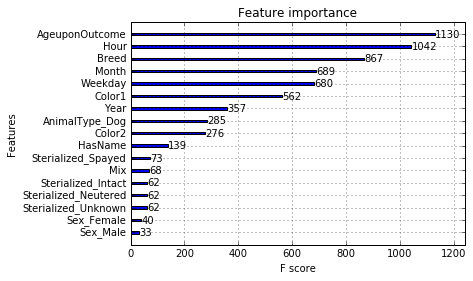

In [80]:
xgb.plot_importance(booster)

In [60]:
preds = booster.predict(xgb.DMatrix(test_xr))

final_results = pd.DataFrame(preds)
final_results.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
# final_results['Died'] = 0
final_results.index.name = 'ID'
final_results.index = final_results.index + 1

final_results = final_results[['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']]

final_results.to_csv('results.csv')

Model stacking

In [81]:
boosters = np.array([])
predictions = []

for i in range(0, 100):
    print("Fitting model #%d" % i)
    %time booster = xgb.train(best_params, xgb.DMatrix(train_xr, train_yt))
    boosters = np.append(boosters, booster)
    predictions.append(booster.predict(xgb.DMatrix(test_xr)))
    

# %time booster = xgb.train(best_params, xgb.DMatrix(train_xr, train_yt))
# np.unique(booster.predict(xgb.DMatrix(test_xr)))

Fitting model #0
CPU times: user 3.56 s, sys: 76 ms, total: 3.64 s
Wall time: 503 ms
Fitting model #1
CPU times: user 7.17 s, sys: 200 ms, total: 7.37 s
Wall time: 1.01 s
Fitting model #2
CPU times: user 4.03 s, sys: 56 ms, total: 4.09 s
Wall time: 517 ms
Fitting model #3
CPU times: user 4.46 s, sys: 88 ms, total: 4.54 s
Wall time: 591 ms
Fitting model #4
CPU times: user 4.56 s, sys: 104 ms, total: 4.66 s
Wall time: 608 ms
Fitting model #5
CPU times: user 4.12 s, sys: 116 ms, total: 4.23 s
Wall time: 541 ms
Fitting model #6
CPU times: user 4.6 s, sys: 92 ms, total: 4.69 s
Wall time: 605 ms
Fitting model #7
CPU times: user 3.92 s, sys: 40 ms, total: 3.96 s
Wall time: 502 ms
Fitting model #8
CPU times: user 4.3 s, sys: 84 ms, total: 4.38 s
Wall time: 560 ms
Fitting model #9
CPU times: user 4.28 s, sys: 68 ms, total: 4.35 s
Wall time: 556 ms
Fitting model #10
CPU times: user 3.94 s, sys: 24 ms, total: 3.96 s
Wall time: 497 ms
Fitting model #11
CPU times: user 3.91 s, sys: 28 ms, total: 3.

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf_models = np.array([])
# predictions = [] already have those

for i in range(0, 10):
    print("Fitting model #%d" % i)
    rf_clf = RandomForestClassifier(n_estimators=300, criterion='gini', n_jobs=8)
    %time rf_clf.fit(train_x, train_yt)
    rf_models = np.append(rf_models, rf_clf)
    predictions.append(rf_clf.predict_proba(test_x))

Fitting model #0
CPU times: user 15.5 s, sys: 236 ms, total: 15.7 s
Wall time: 2.18 s
Fitting model #1
CPU times: user 13.4 s, sys: 220 ms, total: 13.6 s
Wall time: 1.95 s
Fitting model #2
CPU times: user 14 s, sys: 112 ms, total: 14.1 s
Wall time: 2.06 s
Fitting model #3
CPU times: user 14.2 s, sys: 76 ms, total: 14.3 s
Wall time: 2.05 s
Fitting model #4
CPU times: user 13.7 s, sys: 68 ms, total: 13.7 s
Wall time: 1.97 s
Fitting model #5
CPU times: user 13.8 s, sys: 104 ms, total: 13.9 s
Wall time: 1.96 s
Fitting model #6
CPU times: user 13.7 s, sys: 68 ms, total: 13.8 s
Wall time: 1.96 s
Fitting model #7
CPU times: user 13.3 s, sys: 104 ms, total: 13.4 s
Wall time: 1.96 s
Fitting model #8
CPU times: user 13.8 s, sys: 68 ms, total: 13.9 s
Wall time: 1.97 s
Fitting model #9
CPU times: user 13.9 s, sys: 100 ms, total: 14 s
Wall time: 2.06 s


In [83]:
preds = np.mean(predictions, axis = 0)
preds

array([[ 0.27564493,  0.10292153,  0.11734985,  0.19402356,  0.31006015],
       [ 0.48929572,  0.09197608,  0.10034449,  0.18350704,  0.13487664],
       [ 0.25118495,  0.09549495,  0.10061764,  0.15914799,  0.39355453],
       ..., 
       [ 0.08559221,  0.08632697,  0.09857963,  0.08549251,  0.64400868],
       [ 0.37436087,  0.0943853 ,  0.10288206,  0.29764935,  0.1307224 ],
       [ 0.39439087,  0.09521927,  0.10666352,  0.28492222,  0.11880414]])

In [84]:
final_results = pd.DataFrame(preds)
final_results.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
final_results.index.name = 'ID'
final_results.index = final_results.index + 1

final_results = final_results[['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']]

final_results.to_csv('results_stacking.csv')

In [85]:
final_results.shape

(11456, 5)